<h1 style="color: blue;">Exploring Patient Indicators and Identifying Clusters of Diabetes Risk (Goal 1)</h1>

<h1 style="color: blue;">Feature scope (excluding direct diagnostic lab markers)</h1>

Our goal is to model diabetes risk using risk factors rather than direct diagnostic signals. These factors include both
non-modifiable background risk (e.g., age, sex, ethnicity, socioeconomic indicators, family history), and
modifiable or clinically manageable factors (e.g., physical activity, diet patterns, smoking/alcohol, sleep, BMI/waist-to-hip ratio, blood pressure, and lipid profile).

We therefore exclude highly diagnostic laboratory markers: fasting and postprandial glucose levels, insulin level, and HbA1c—from the main EDA, clustering, and modelling. Because these markers sit very close to how diabetes is diagnosed, they tend to overwhelm the analysis and make everything look artificially easy, particularly with synthetic data. For the same reason, we also exclude the variable diabetes_risk_score, which is itself derived from several underlying risk factors and would act as an almost-direct shortcut to the outcome rather than an independent predictor.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
LAB_MARKERS = ["glucose_fasting", "glucose_postprandial", "insulin_level", "hba1c", 'diabetes_risk_score']
df_before = pd.read_csv("../data/diabetes_dataset.csv")

df = df_before.drop(columns=[c for c in LAB_MARKERS if c in df_before.columns]).copy()


<h1 style="color: blue;">Data quality checks</h1>

We check:
1) class balance (targets),
2) missing values,
3) duplicate rows,
4) basic validation (range, consistency).

In [3]:
print("Shape:", df.shape)
df.head()


Shape: (100000, 26)


,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,0.89,134,78,68,239,41,160,145,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,0.80,129,76,67,116,55,50,30,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,0.81,115,73,74,213,66,99,36,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,0.88,120,93,68,171,50,79,140,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,0.78,92,67,67,210,52,125,160,Type 2,1


### 1) Class balance

In this step we examine how the target variables are distributed. We compute the counts and proportions for `diagnosed_diabetes` 
and for each category of `diabetes_stage` to see whether some classes are much more frequent than others. 
This helps us understand class imbalance, which is important for choosing suitable evaluation metrics and interpreting model performance.

In [4]:
# 1) Class balance (imbalance)
print("diagnosed_diabetes distribution:")
print(df["diagnosed_diabetes"].value_counts(dropna=False))
print("\nProportions:")
print(df["diagnosed_diabetes"].value_counts(normalize=True, dropna=False))

print("\ndiabetes_stage distribution:")
print(df["diabetes_stage"].value_counts(dropna=False))
print("\nProportions:")
print(df["diabetes_stage"].value_counts(normalize=True, dropna=False))


diagnosed_diabetes distribution:
diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64

Proportions:
diagnosed_diabetes
1    0.59998
0    0.40002
Name: proportion, dtype: float64

diabetes_stage distribution:
diabetes_stage
Type 2          59774
Pre-Diabetes    31845
No Diabetes      7981
Gestational       278
Type 1            122
Name: count, dtype: int64

Proportions:
diabetes_stage
Type 2          0.59774
Pre-Diabetes    0.31845
No Diabetes     0.07981
Gestational     0.00278
Type 1          0.00122
Name: proportion, dtype: float64


#### Results

The binary target `diagnosed_diabetes` is slightly imbalanced: about 60% of patients have diagnosed diabetes and 40% do not. The multi-class target `diabetes_stage` is strongly imbalanced: most patients are classified as Type 2 (≈60%) or Pre-Diabetes (≈32%), while No Diabetes is less frequent (≈8%) and Type 1 and Gestational are very rare (<1% together).

### Excluding Type 1 and Gestational cases

Type 1 and Type 2 diabetes are medically distinct conditions. Type 1 is an autoimmune disease where the pancreas stops producing insulin, and it is not related to lifestyle or metabolic risk factors. Type 2 develops through insulin resistance and is strongly associated with age, adiposity, physical inactivity, lipids and blood pressure. Gestational diabetes occurs only during pregnancy and represents a separate clinical pathway. Since the present study focuses on risk factors that are relevant for Type 2 diabetes and pre-diabetes, and because Type 1 and Gestational diabetes were very rare in the data (<0.5%), these categories were excluded before analysis. All modelling and clustering are therefore based on the remaining categories: No Diabetes, Pre-Diabetes and Type 2.

In [5]:
df_original = df.copy()

df = df[df["diabetes_stage"].isin(["No Diabetes", "Pre-Diabetes", "Type 2"])].copy()

df_before = df_original.shape[0]
df_after = df.shape[0]

print("Removed rows:", df_before - df_after)
print("Removed %:", round((df_before - df_after) / df_before * 100, 3), "%")
print("New shape:", df.shape)

Removed rows: 400
Removed %: 0.4 %
New shape: (99600, 26)


### 2) Missing values

In [6]:
# 2) Missing values
missing = int(df.isna().sum().sum())
print("Missing values:", missing)

Missing values: 0


### 3) Duplicate rows

In [7]:
# 3) Duplicate rows 

# Exact duplicate rows (all columns identical)
dup_all = df.duplicated().sum()
print("Exact duplicate rows (all columns):", dup_all)

# Duplicates based on all feature columns (excluding targets)
possible_targets = ["diagnosed_diabetes", "diabetes_stage"]
feature_cols = [c for c in df.columns if c not in possible_targets]

dup_features = df.duplicated(subset=feature_cols).sum()
print("Duplicate rows based on features (ignoring targets):", dup_features)

Exact duplicate rows (all columns): 0
Duplicate rows based on features (ignoring targets): 0


In [8]:
# 4) Basic validation

import numpy as np
import pandas as pd

# numeric columns
num_cols = df.select_dtypes(include="number").columns

# 1) Binary columns
binary_like = [c for c in num_cols if df[c].nunique(dropna=False) < 3]
print("Binary columns:", binary_like)
for c in binary_like:
    print(f"{c}: unique values =", np.sort(df[c].unique()))

# 2) Continuous numeric columns (exclude binary)
continuous_cols = [c for c in num_cols if c not in binary_like]

print("\nContinuous feature min/max ranges:")
df[continuous_cols].describe().T[["min", "max"]]


Binary columns: ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']
family_history_diabetes: unique values = [0 1]
hypertension_history: unique values = [0 1]
cardiovascular_history: unique values = [0 1]
diagnosed_diabetes: unique values = [0 1]

Continuous feature min/max ranges:


,min,max
age,18.00,90.00
alcohol_consumption_per_week,0.00,10.00
physical_activity_minutes_per_week,0.00,833.00
diet_score,0.00,10.00
sleep_hours_per_day,3.00,10.00
screen_time_hours_per_day,0.50,16.80
bmi,15.00,39.20
waist_to_hip_ratio,0.67,1.06
systolic_bp,90.00,179.00
diastolic_bp,50.00,110.00


#### Results
Binary numeric columns all contain valid values only.  
For continuous numeric features, the min–max ranges are medically plausible (e.g., age 18–90, BMI 15–39, realistic blood pressure and glucose values).  
No impossible values were found, so no range-based filtering was needed.

<h1 style="color: blue;">Exploratory Data Analysis</h1>

We check:
1) descriptive statistics,
2) group comparisons (diabetes vs no diabetes),
3) distribution analysis of key predictors,
4) categorical features and diabetes prevalence,
5) correlation analysis,
6) summary of exploratory findings.

### 1) Descriptive statistics

In this step we summarise the dataset structure and numerical feature ranges using 
df.info() and df.describe(). This helps verify that data types are correct and that 
values fall within medically plausible limits.

In [9]:
# 1) Descriptive statistics
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Index: 99600 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 99600 non-null  int64  
 1   gender                              99600 non-null  object 
 2   ethnicity                           99600 non-null  object 
 3   education_level                     99600 non-null  object 
 4   income_level                        99600 non-null  object 
 5   employment_status                   99600 non-null  object 
 6   smoking_status                      99600 non-null  object 
 7   alcohol_consumption_per_week        99600 non-null  int64  
 8   physical_activity_minutes_per_week  99600 non-null  int64  
 9   diet_score                          99600 non-null  float64
 10  sleep_hours_per_day                 99600 non-null  float64
 11  screen_time_hours_per_day           99600 non-

,count,mean,std,min,25%,50%,75%,max
age,99600.0,50.186968,15.593027,18.00,39.00,50.00,61.00,90.00
alcohol_consumption_per_week,99600.0,2.003554,1.417832,0.00,1.00,2.00,3.00,10.00
physical_activity_minutes_per_week,99600.0,118.906406,84.414436,0.00,57.00,100.00,160.00,833.00
diet_score,99600.0,5.994688,1.780715,0.00,4.80,6.00,7.20,10.00
sleep_hours_per_day,99600.0,6.997926,1.094681,3.00,6.30,7.00,7.70,10.00
screen_time_hours_per_day,99600.0,5.996369,2.468157,0.50,4.30,6.00,7.70,16.80
family_history_diabetes,99600.0,0.219468,0.413888,0.00,0.00,0.00,0.00,1.00
hypertension_history,99600.0,0.251155,0.433679,0.00,0.00,0.00,1.00,1.00
cardiovascular_history,99600.0,0.079418,0.270391,0.00,0.00,0.00,0.00,1.00
bmi,99600.0,25.615464,3.585877,15.00,23.20,25.60,28.00,39.20


### 2) Group comparisons (diabetes vs no diabetes)

We compare mean values of key clinical and lifestyle features between patients 
with and without diagnosed diabetes. This allows us to identify which variables 
show the largest differences between groups.

In [10]:
# 2) Group comparisons (diabetes vs no diabetes)
key_num_cols = [
    "age",
    "bmi",
    "waist_to_hip_ratio",
    "systolic_bp",
    "diastolic_bp",
    "heart_rate",
    "cholesterol_total",
    "hdl_cholesterol",
    "ldl_cholesterol",
    "triglycerides",
    "physical_activity_minutes_per_week",
    "diet_score",
    "sleep_hours_per_day",
    "screen_time_hours_per_day",
    "alcohol_consumption_per_week",
]
key_num_cols = [c for c in key_num_cols if c in df.columns]

group_means = df.groupby("diagnosed_diabetes")[key_num_cols].mean().T.round(2)
group_means

diagnosed_diabetes,0,1
age,47.56,51.94
bmi,25.19,25.90
waist_to_hip_ratio,0.85,0.86
systolic_bp,114.17,116.95
diastolic_bp,74.89,75.48
heart_rate,69.40,69.79
cholesterol_total,183.73,187.55
hdl_cholesterol,54.69,53.61
ldl_cholesterol,100.27,104.89
triglycerides,118.49,123.45


#### Results
The largest differences between groups are observed in age and lifestyle/health indicators such as physical activity (lower in the diabetes group) and lipid markers (higher triglycerides/LDL and lower HDL). Differences in BMI/waist-to-hip ratio and blood pressure are present but relatively small, suggesting that risk is driven by a combination of factors rather than one dominant non-lab variable.

### 3) Distribution analysis of key predictors

We visualise the distributions (KDE plots) of six important markers: age, physical activity, bloodpressure, tryglycerides level, ldl cholesterol and bmi.

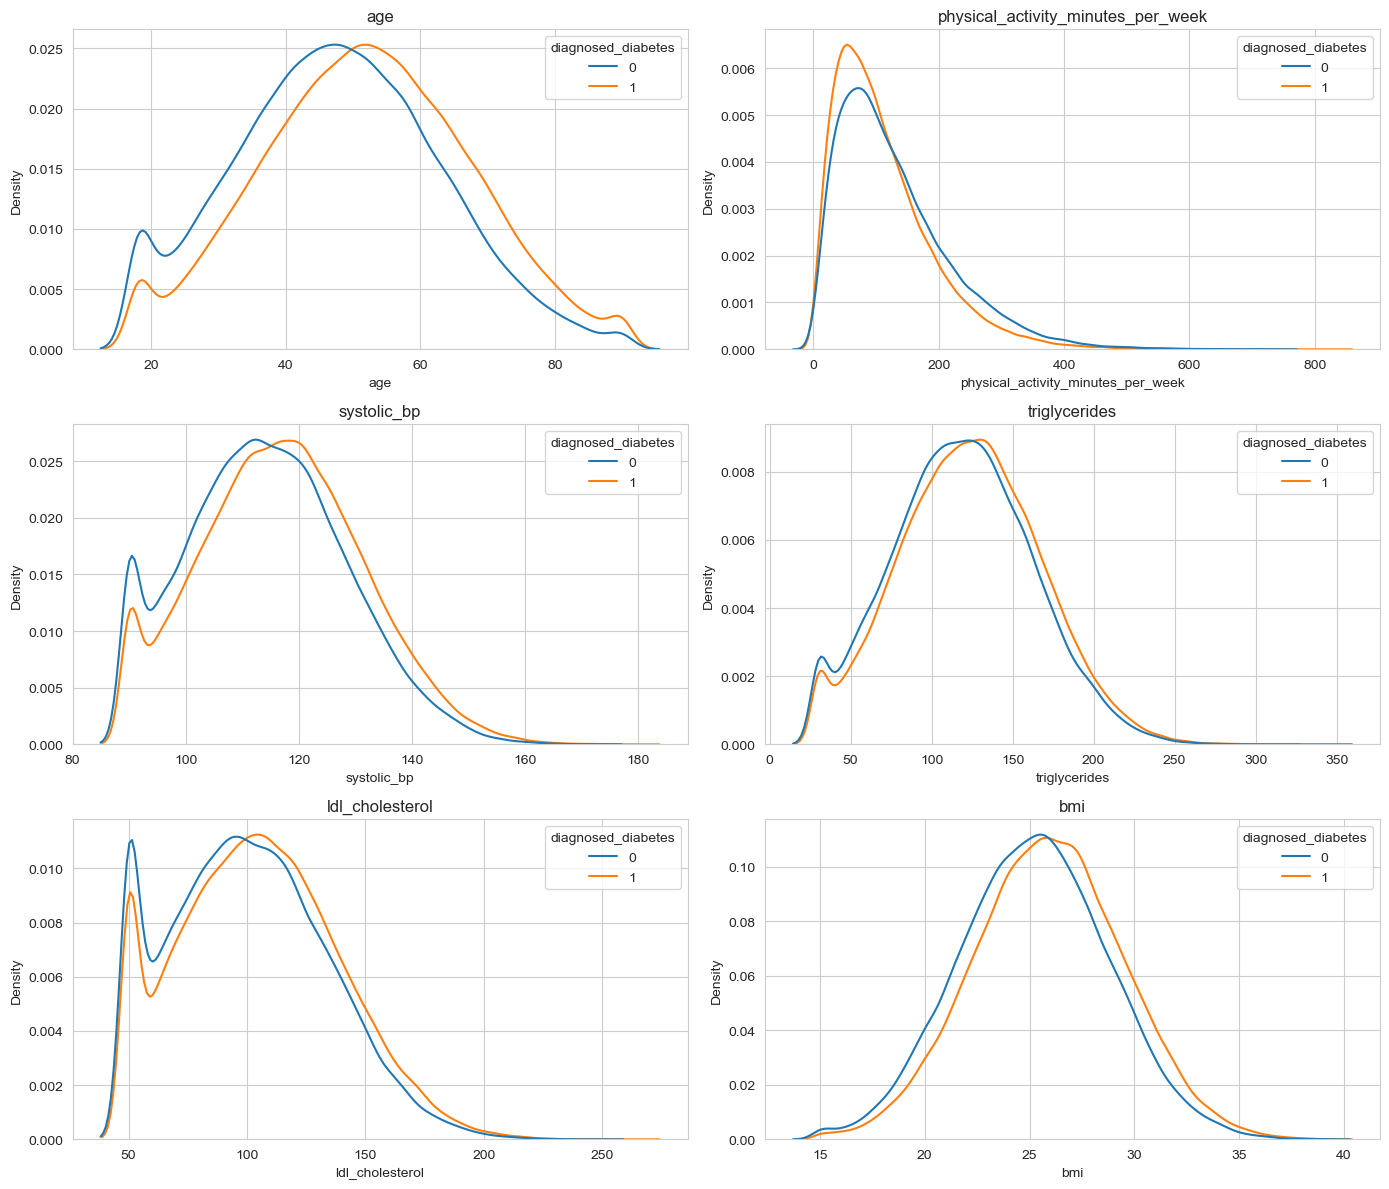

In [11]:
sns.set_style("whitegrid")

key_predictors = [
    "age",
    "physical_activity_minutes_per_week",
    "systolic_bp",
    "triglycerides",
    "ldl_cholesterol",
    "bmi",
]
key_predictors = [c for c in key_predictors if c in df.columns]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, col in zip(axes, key_predictors):
    sns.kdeplot(data=df, x=col, hue="diagnosed_diabetes", common_norm=False, ax=ax)
    ax.set_title(col)
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()


#### Results 

The KDE plots show clear group shifts in several risk factors. Individuals with diagnosed diabetes tend to be older and report lower physical activity, while systolic blood pressure, triglycerides, LDL cholesterol, and BMI are generally higher (right-shift/heavier right tail) compared to the non-diabetes group. Overall, age and activity show the strongest separation, with cardiometabolic markers providing additional but smaller shifts.

### 4) Categorical features and diabetes prevalence

We examine how diabetes prevalence differs across demographic and behavioural categories by computing, for each category level (e.g. gender, ethnicity, smoking status, education, income, employment, family and medical history), the proportion of individuals with diagnosed diabetes. These proportions are shown as bar plots, with a dashed horizontal line indicating the overall prevalence (~60%), which makes it easy to see which groups lie above or below the dataset average.

In [38]:
df_plot = df.copy()

for col in df_plot.columns:
    if col in ["diagnosed_diabetes", "diabetes_stage"]:
        continue

    uniques = df_plot[col].dropna().unique()
    if set(uniques) == {0, 1}:
        df_plot[col] = df_plot[col].map({0: "No", 1: "Yes"})

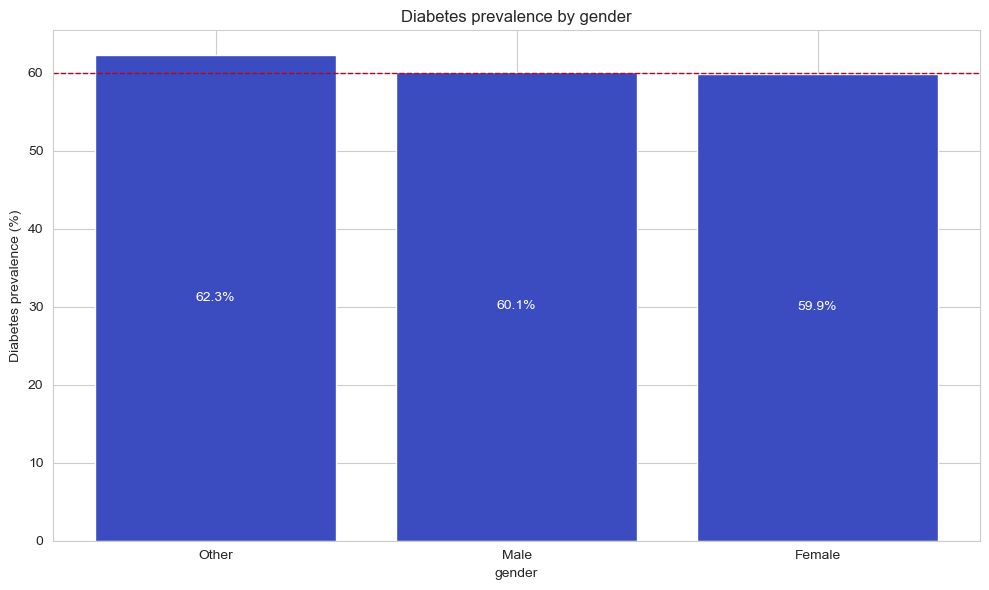

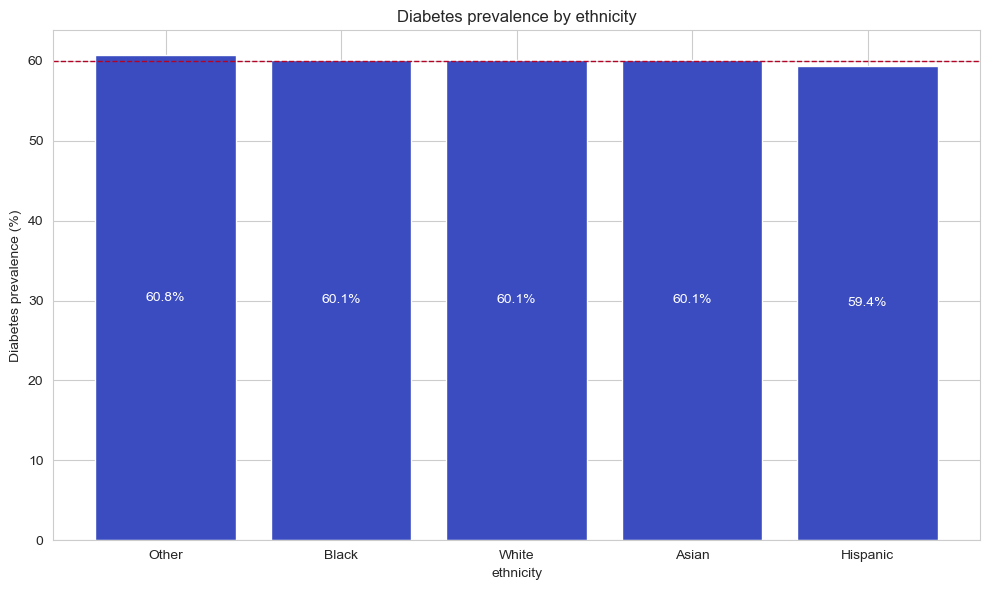

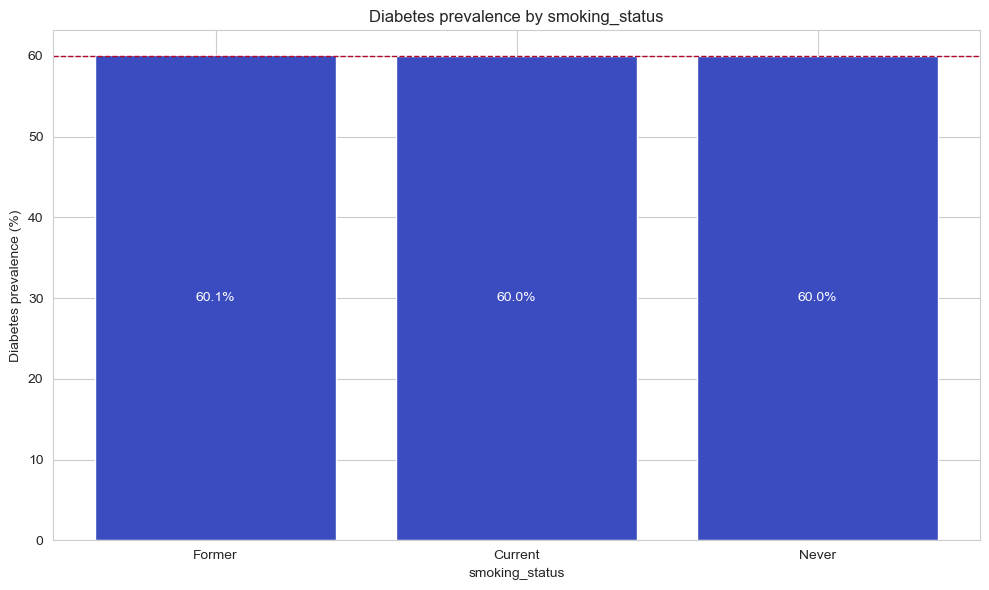

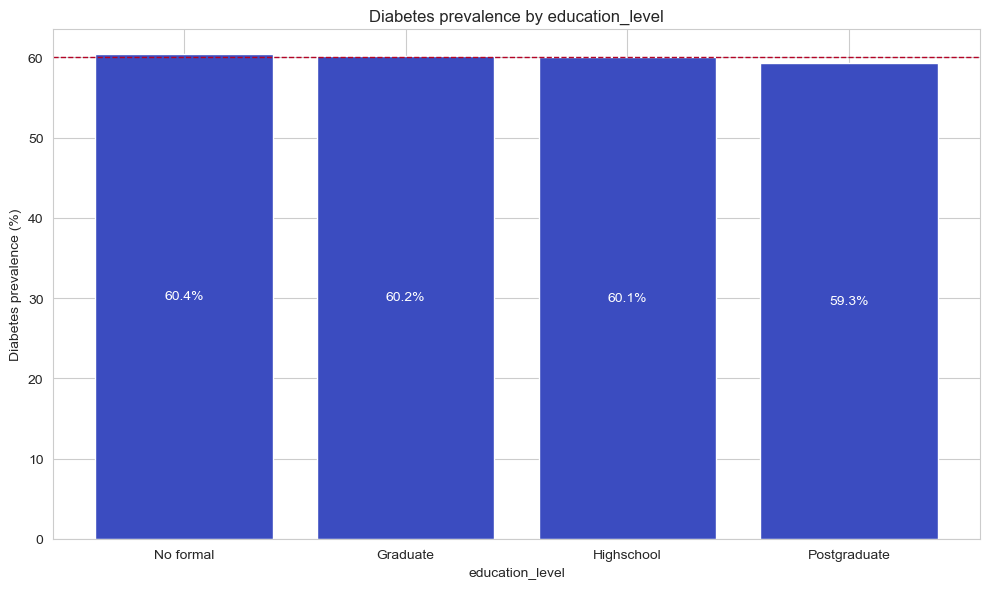

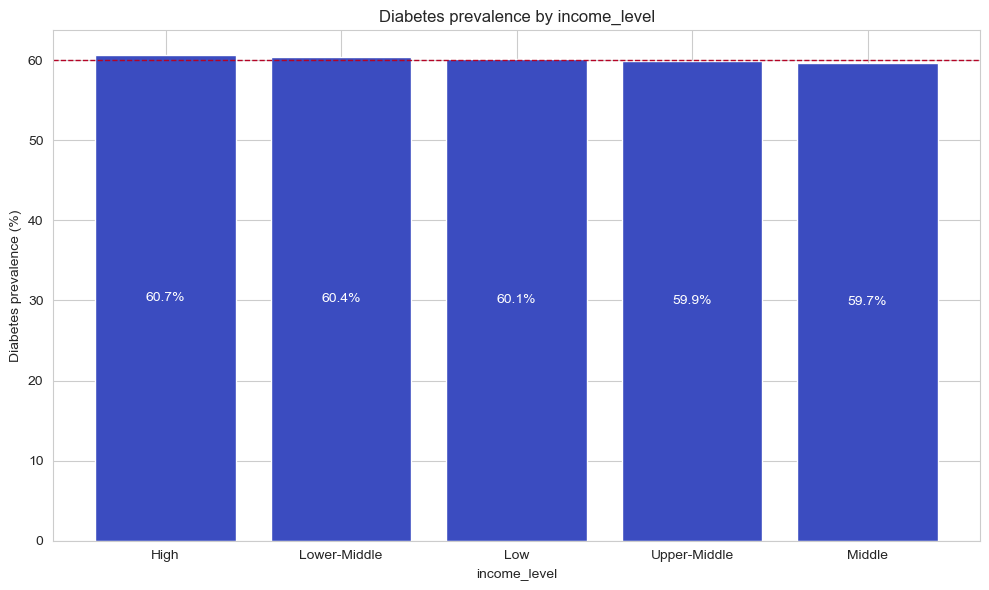

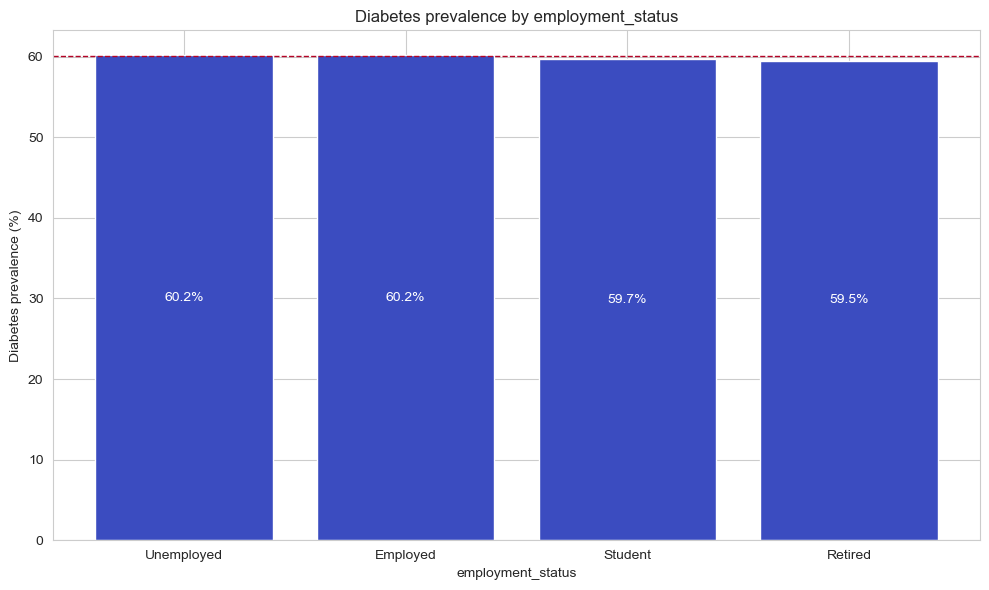

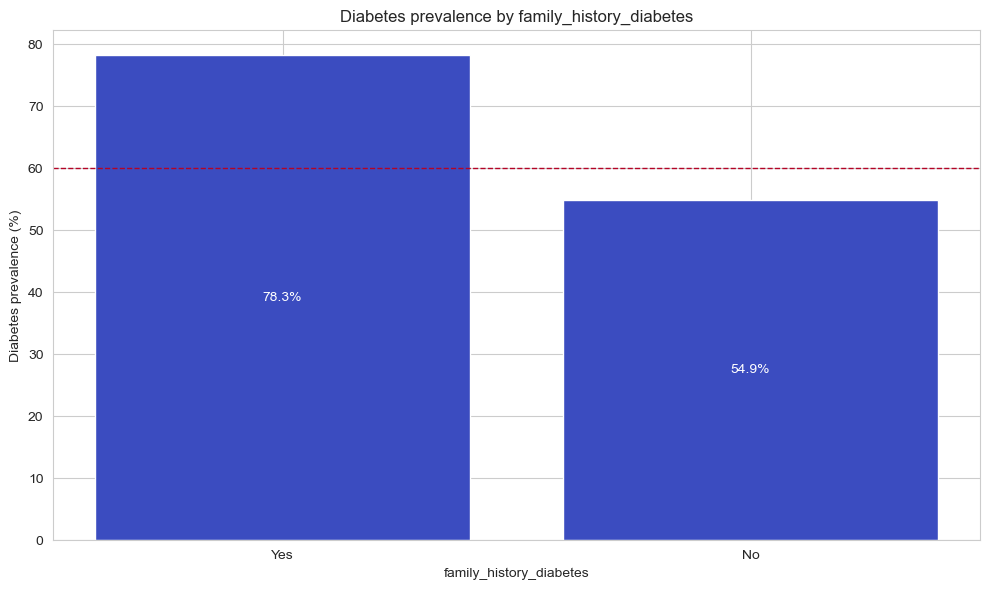

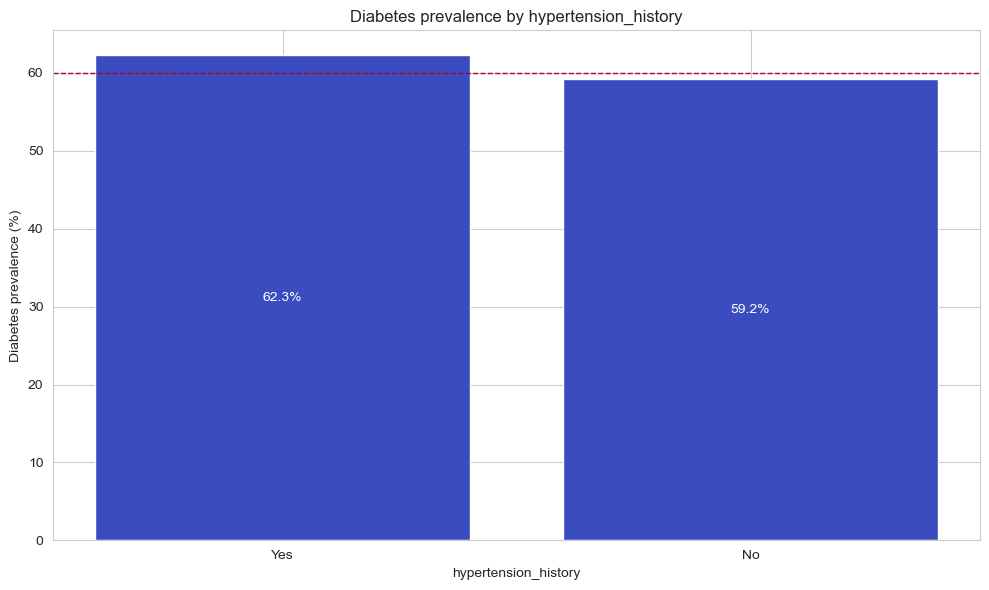

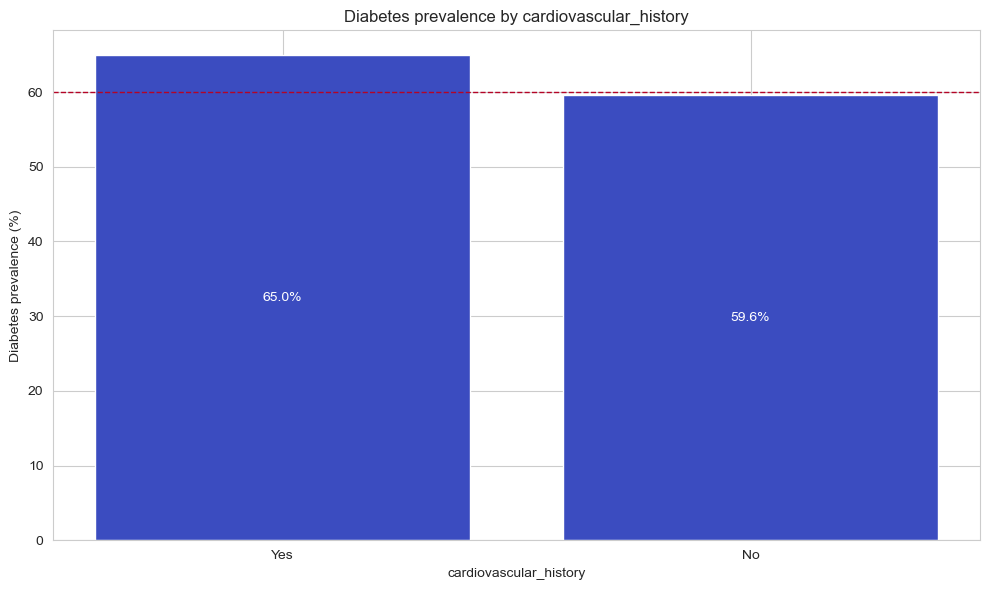

In [39]:
cat_cols = ["gender","ethnicity","smoking_status","education_level",
            "income_level","employment_status",
            "family_history_diabetes","hypertension_history","cardiovascular_history"]
cat_cols = [c for c in cat_cols if c in df_plot.columns]
dark_blue = plt.cm.coolwarm(0.0)
baseline_red = plt.cm.coolwarm(1.0) 

for col in cat_cols:
    prev = (df_plot.groupby(col)["diagnosed_diabetes"].mean()*100).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(prev.index, prev.values, color=dark_blue)
    plt.ylabel("Diabetes prevalence (%)")
    plt.xlabel(col)
    plt.title(f"Diabetes prevalence by {col}")

    for bar, value in zip(bars, prev.values):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height * 0.5,
            f"{value:.1f}%",
            ha="center", va="center",
            fontsize=10,
            color="white" if height > 10 else "black",
        )
        
    plt.axhline((df["diagnosed_diabetes"].mean()*100), linestyle="--", linewidth=1, color=baseline_red)  # overall baseline
    plt.tight_layout()
    plt.savefig(f"{col}_prevalence.svg", format="svg")
    plt.show()

#### Results
Diabetes prevalence is very similar across most demographic and socioeconomic categories – gender, ethnicity, education level, income level, employment status and smoking status all stay close to the overall baseline of about 60%. In contrast, the strongest separation appears in medical history variables: individuals with a family history of diabetes have clearly higher prevalence (about 75–80%) than those without (about 55%), and a history of hypertension or cardiovascular disease is also associated with a slightly higher prevalence than in those without these conditions.

### 5) Correlation analysis

To identify which numerical features are most strongly associated with diabetes,  we compute the correlation matrix and extract the variables with the strongest positive correlations with the target variable `diagnosed_diabetes`.

In [13]:
corr = df.corr(numeric_only=True)
target_corr = corr["diagnosed_diabetes"].sort_values(ascending=False)
target_corr = target_corr.drop("diagnosed_diabetes")

styled = target_corr.to_frame("Correlation with diabetes").style.background_gradient(
    cmap="coolwarm").set_properties(**{"font-size": "14px"}).set_caption("Feature correlations with diagnosed_diabetes")

styled

,Correlation with diabetes
family_history_diabetes,0.197809
age,0.137715
bmi,0.096928
systolic_bp,0.095346
waist_to_hip_ratio,0.078638
ldl_cholesterol,0.067705
cholesterol_total,0.058427
triglycerides,0.056075
diastolic_bp,0.035606
cardiovascular_history,0.029857


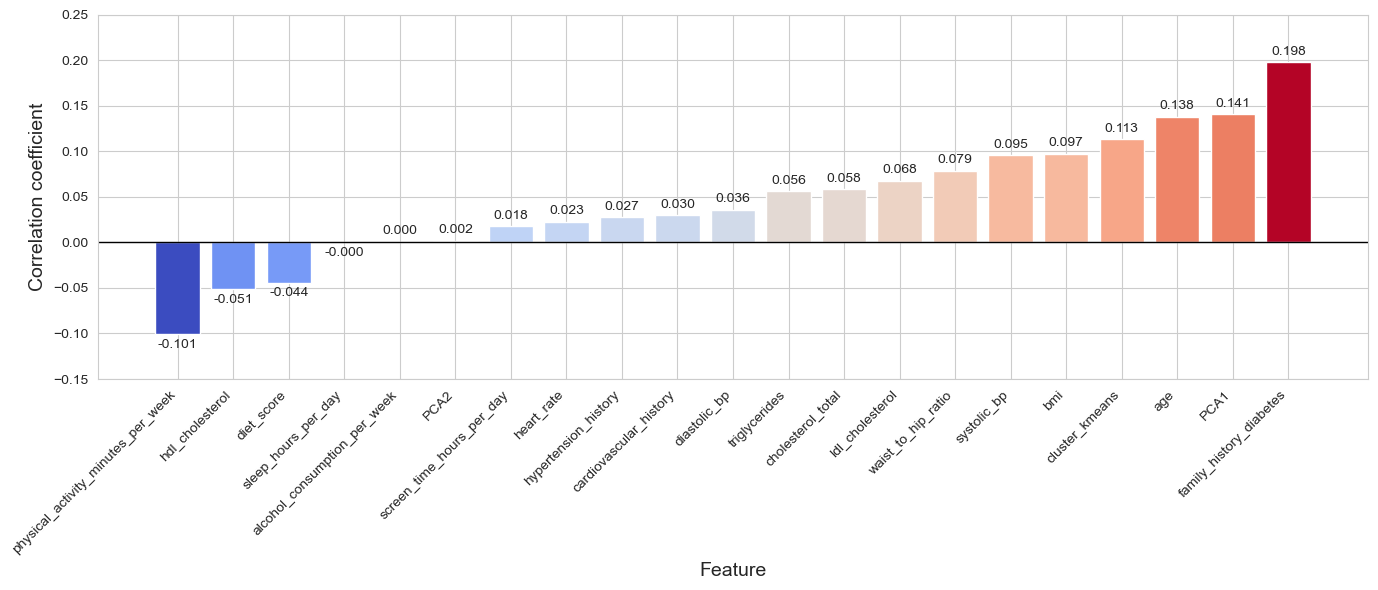

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

corr = df.corr(numeric_only=True)
target_corr = corr["diagnosed_diabetes"].drop("diagnosed_diabetes").sort_values()

values = target_corr.values
features = target_corr.index

norm = (values - values.min()) / (values.max() - values.min())
cmap = plt.get_cmap("coolwarm")
colors = cmap(norm)

fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(features, values, color=colors)

ax.set_ylabel("Correlation coefficient", fontsize=14)
ax.set_xlabel("Feature", fontsize=14)
ax.axhline(0, color="black", linewidth=1)
ax.set_ylim(-0.15, 0.25)

for bar, v in zip(bars, values):
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    label = f"{v:.3f}"

    if height >= 0:
        ax.text(x, height + 0.005, label, ha="center", va="bottom", fontsize=10)
    else:
        ax.text(x, height - 0.005, label, ha="center", va="top", fontsize=10)

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig("correlation_vertical_colormap2.svg", format="svg")
plt.show()

#### Results
The correlation analysis showed that the relationships between individual predictors and diagnosed_diabetes were generally weak (|r| ≤ 0.20). The strongest associations were observed for family_history_diabetes (r = 0.20), followed by age (r = 0.14), BMI (r = 0.10) and systolic blood pressure (r ≈ 0.10).

Lipid measures (LDL cholesterol, triglycerides, total cholesterol) and diastolic blood pressure showed small positive correlations with diabetes (r ≈ 0.04–0.07). Lifestyle variables had even smaller associations: diet score, sleep hours, alcohol consumption and screen time were all close to zero. The only clear protective factor was physical activity minutes per week, which showed a small negative relationship (r = –0.10), indicating that higher physical activity was associated with a lower prevalence of diabetes.

Overall, no single predictor displayed a strong linear relationship with diabetes, suggesting that risk is multifactorial. This supports the use of multivariate models to capture the combined effect of several upstream predictors.

### 6) Summary of exploratory findings

The dataset contains 100,000 synthetic patient records with 31 variables covering demographics, lifestyle behaviours, clinical measurements and two diabetes-related outcomes. The data is complete and clean: no missing values or duplicate rows were found, and all numerical features lie within plausible medical ranges, so no major preprocessing was required before analysis. In line with our aim to focus on upstream risk factors, we excluded highly diagnostic laboratory markers (fasting and postprandial glucose, insulin and HbA1c) as well as the composite diabetes_risk_score from the main exploratory analysis and subsequent modelling.

Class balance analysis shows that diagnosed_diabetes is moderately imbalanced (≈60% positive), while the original multi-class outcome diabetes_stage was more strongly imbalanced. Type 2 and Pre-Diabetes were common, whereas Type 1 and Gestational cases occurred only in very small proportions (<0.5%). Since these rare categories were not relevant for the current risk-factor focus and would add little to model evaluation, they were removed before analysis.

Exploratory analysis shows clear but generally modest and clinically plausible differences between individuals with and without diabetes when focusing on non-laboratory risk factors. Participants with diagnosed diabetes tend to be older, less physically active and have slightly higher BMI, waist-to-hip ratio, systolic blood pressure and less favourable lipid profiles (higher LDL cholesterol and triglycerides). In contrast, several lifestyle-related variables such as sleep duration, alcohol consumption and screen time show only minimal differences between groups. Categorical variables (gender, ethnicity, smoking status, education, income, employment) exhibit only small deviations from the overall diabetes prevalence, whereas medical history variables—particularly family history of diabetes, and to a lesser extent history of hypertension or cardiovascular disease—are associated with visibly higher diabetes prevalence.

Correlation analysis further supports these patterns. Individual predictors show mostly weak linear relationships with diagnosed_diabetes, with the strongest associations observed for family_history_diabetes, followed by age, BMI and systolic blood pressure, while lipid markers and other lifestyle variables display only small positive or near-zero correlations; physical activity shows a small negative correlation, consistent with a protective effect. Overall, the exploratory data analysis suggests that, in the absence of direct diagnostic markers, diabetes risk in this dataset is shaped by the combined contribution of several modest demographic, behavioural and clinical risk factors rather than a single dominant variable. These insights motivate the use of multivariate models to capture the joint effect of upstream predictors in the subsequent modelling tasks.

<h1 style="color: blue;">Clustering and Risk Profile Discovery</h1>

We check:
1) preparing the clustering dataset,
2) selecting the number of clusters,
3) K-means clustering,
4) cluster profiles (numerical features),
5) cluster–outcome relationships
6) PCA visualisation of clusters,
7) hierarchical clustering (sample.

### 1) Preparing the clustering dataset

For clustering we remove the target variables (`diagnosed_diabetes`, `diabetes_stage`) and the precomputed `diabetes_risk_score` to avoid leakage. The remaining predictors are split into numerical and categorical features. Numerical variables are standardised and categorical variables are one-hot encoded using a `ColumnTransformer`. This ensures that all features contribute on a comparable scale to the distance calculations in K-means and hierarchical clustering.

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop targets + leakage variable
cluster_df = df.drop(columns=["diagnosed_diabetes", "diabetes_stage"])

# Identify numeric and categorical columns
num_cols = cluster_df.select_dtypes(include="number").columns.tolist()
cat_cols = cluster_df.select_dtypes(exclude="number").columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

X = preprocess.fit_transform(cluster_df)
feature_names = preprocess.get_feature_names_out()
len(feature_names), feature_names

Numeric columns: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides']
Categorical columns: ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status']


(42,
 array(['num__age', 'num__alcohol_consumption_per_week',
        'num__physical_activity_minutes_per_week', 'num__diet_score',
        'num__sleep_hours_per_day', 'num__screen_time_hours_per_day',
        'num__family_history_diabetes', 'num__hypertension_history',
        'num__cardiovascular_history', 'num__bmi',
        'num__waist_to_hip_ratio', 'num__systolic_bp', 'num__diastolic_bp',
        'num__heart_rate', 'num__cholesterol_total',
        'num__hdl_cholesterol', 'num__ldl_cholesterol',
        'num__triglycerides', 'cat__gender_Female', 'cat__gender_Male',
        'cat__gender_Other', 'cat__ethnicity_Asian',
        'cat__ethnicity_Black', 'cat__ethnicity_Hispanic',
        'cat__ethnicity_Other', 'cat__ethnicity_White',
        'cat__education_level_Graduate', 'cat__education_level_Highschool',
        'cat__education_level_No formal',
        'cat__education_level_Postgraduate', 'cat__income_level_High',
        'cat__income_level_Low', 'cat__income_level_Lower-Middle

### 2) Selecting the number of clusters

To determine a suitable number of clusters, we evaluate different values of *k* using two diagnostics:

- **Elbow method**, which plots the within-cluster inertia and helps identify diminishing returns when increasing *k*.
- **Silhouette score**, which measures how well-separated and cohesive the clusters are (higher is better).

We test values of k between 2 and 9 and inspect both curves to select the most appropriate number of clusters for this dataset.

C:\Users\helenaraask\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\helenaraask\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\helenaraask\AppData\Local\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\helenaraask\AppData\Local\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(ar

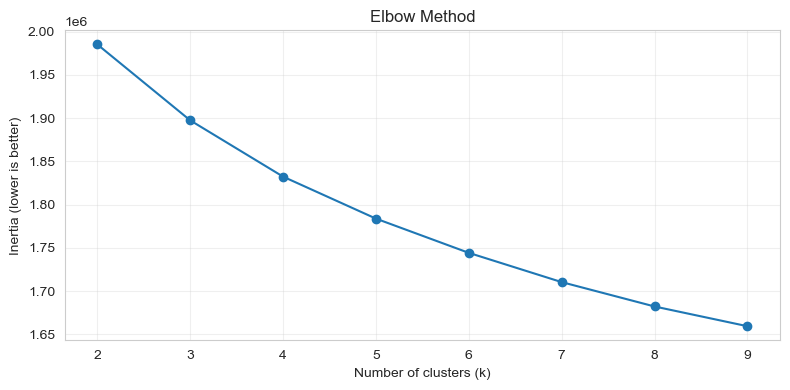

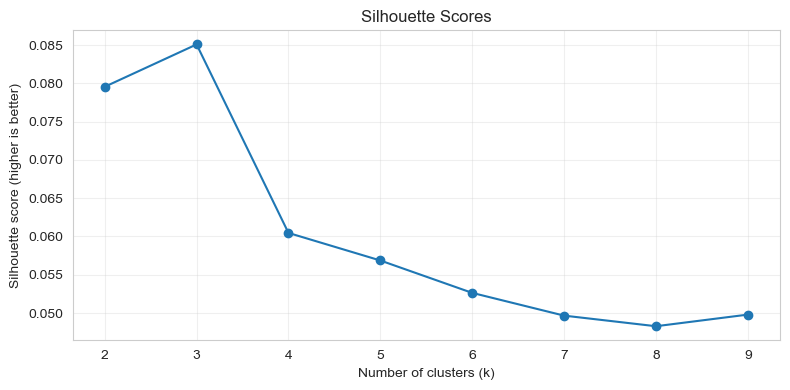

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

K_range = range(2, 10)
inertias = []
sil_scores = []

sample_size = 5000 if X.shape[0] > 5000 else X.shape[0]

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)

    inertias.append(km.inertia_)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Could not find the number of physical cores")
        score = silhouette_score(X, labels, sample_size=sample_size, random_state=42)
    sil_scores.append(score)

# Elbow plot
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (lower is better)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Silhouette plot
plt.figure(figsize=(8, 4))
plt.plot(K_range, sil_scores, marker="o")
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score (higher is better)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### Result 
We evaluated different values of k using the elbow method and silhouette scores. The inertia curve decreased steadily with increasing k, without a very sharp elbow, which is typical when clusters are not strongly separated. The silhouette scores showed a maximum at k = 3, indicating that this solution was the most compact and well-separated among the tested values.

### 3) K-means clustering

We set the number of clusters to k = 3. We then fitted a K-means model inside a pipeline that also includes one-hot encoding and feature scaling, so that the same preprocessing is always applied. Each observation was assigned to one of the three clusters, and the resulting cluster labels were stored as a new column in the analysis dataset for subsequent profiling and modelling.

In [17]:
k = 3

kmeans_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("kmeans", KMeans(n_clusters=k, random_state=1, n_init=10))
])

cluster_labels = kmeans_pipeline.fit_predict(cluster_df)

df["cluster_kmeans"] = cluster_labels

initial_rate = df.groupby("cluster_kmeans")["diagnosed_diabetes"].mean()
print("Initial diabetes rates:\n", initial_rate)


order = initial_rate.sort_values().index     

label_map = {old_label: new_label for new_label, old_label in enumerate(order)}
print("Label map:", label_map)

df["cluster_kmeans"] = df["cluster_kmeans"].map(label_map)


Initial diabetes rates:
 cluster_kmeans
0    0.665479
1    0.604053
2    0.532784
Name: diagnosed_diabetes, dtype: float64
Label map: {2: 0, 1: 1, 0: 2}


#### Result

After excluding the rare diabetes categories, the three-cluster solution produced groups of comparable size (30–35% each). This is advantageous because none of the clusters are disproportionately small or large, which makes the descriptive comparisons more stable and easier to interpret.

### 4) Cluster profiles (numerical features)
To understand how the clusters differ, we compare the average values of risk factors across clusters. This comparison helps identify which clusters correspond to healthier profiles (younger, more active, lower BMI and blood pressure) and which represent higher-risk patterns (older, less active, higher adiposity and cardiovascular indicators).

In [18]:
num_cols = df.select_dtypes(include=["number"]).columns.drop("cluster_kmeans")

cluster_means = df.groupby("cluster_kmeans")[num_cols].mean()

variation = cluster_means.max() - cluster_means.min()
cluster_means = cluster_means.loc[:, variation.sort_values(ascending=False).index]

cluster_means.style.format("{:.2f}").background_gradient(cmap="Blues")


,ldl_cholesterol,triglycerides,cholesterol_total,physical_activity_minutes_per_week,age,systolic_bp,hdl_cholesterol,bmi,diastolic_bp,diet_score,heart_rate,alcohol_consumption_per_week,hypertension_history,diagnosed_diabetes,cardiovascular_history,waist_to_hip_ratio,screen_time_hours_per_day,sleep_hours_per_day,family_history_diabetes
cluster_kmeans,,,,,,,,,,,,,,,,,,,
0,86.87,95.99,172.86,128.89,46.10,110.11,57.59,22.37,73.17,6.54,69.18,1.93,0.23,0.53,0.07,0.82,6.02,7.00,0.22
1,87.33,141.01,169.99,110.01,42.85,112.57,53.13,27.61,75.11,5.53,70.17,2.11,0.18,0.60,0.04,0.88,6.00,6.99,0.22
2,133.51,130.14,213.71,116.61,60.88,124.59,51.22,27.16,77.48,5.85,69.63,1.99,0.34,0.67,0.13,0.87,5.97,7.00,0.22


#### Results - cluster profiles

##### Cluster 2 — Higher risk metabolic profile
- Highest LDL cholesterol, triglycerides and total cholesterol  
- Higher systolic and diastolic blood pressure  
- Higher BMI and waist-to-hip ratio  
- Older age on average  
- Highest prevalence of diagnosed diabetes (≈ 67%)  
- More frequent hypertension and cardiovascular history  
→ Represents individuals with the most adverse cardio-metabolic markers.

##### Cluster 1 — Intermediate profile
- Lipid levels and blood pressure moderately elevated  
- BMI and waist-to-hip ratio slightly above Cluster 0  
- Age between the other two clusters  
- Diabetes prevalence at an intermediate level (≈ 60%)  
→ Can be interpreted as a moderate-risk group.

##### Cluster 0 — Lower risk profile
- Lowest LDL cholesterol, triglycerides and total cholesterol  
- Lower blood pressure  
- Lower BMI and more favourable waist-to-hip ratio  
- Slightly younger and physically more active  
- Lowest diabetes rate (≈ 53%)  
→ Appears metabolically healthier overall.

Lifestyle variables (diet, sleep, alcohol, screen time) were very similar across clusters, suggesting that clustering was mainly driven by clinical markers (lipids, blood pressure, adiposity) rather than behavioural factors.


### 5) Cluster–outcome relationships

To determine whether the clusters correspond to meaningful health outcomes, we compare 
(1) the prevalence of diagnosed diabetes and 
(2) the distribution of diabetes stages within each cluster.

If clustering has captured real metabolic differences, we expect clusters with worse health profiles to contain more diagnosed diabetes and more advanced disease stages. These relationships help interpret each cluster as lower-, medium-, or higher-risk groups.

In [19]:
# Diabetes rate (binary outcome)
diabetes_rate = df.groupby("cluster_kmeans")["diagnosed_diabetes"].mean().round(3)
diabetes_rate

cluster_kmeans
0    0.533
1    0.604
2    0.665
Name: diagnosed_diabetes, dtype: float64

In [20]:
# Diabetes stage distribution (multiclass outcome)
stage_distribution = (
    df.groupby("cluster_kmeans")["diabetes_stage"]
    .value_counts(normalize=True)
    .rename("proportion")
    .mul(100)
    .round(1)
)
stage_distribution

cluster_kmeans  diabetes_stage
0               Type 2            53.3
                Pre-Diabetes      35.6
                No Diabetes       11.1
1               Type 2            60.4
                Pre-Diabetes      31.9
                No Diabetes        7.7
2               Type 2            66.5
                Pre-Diabetes      28.3
                No Diabetes        5.2
Name: proportion, dtype: float64

#### Results

The clusters were compared against diabetes outcomes. The prevalence of diagnosed_diabetes differed only modestly between clusters, ranging from 0.53 in Cluster 2 to 0.67 in Cluster 0 (Cluster 1: 0.60). This pattern is consistent with the cluster profiles: Cluster 2 showed the most favourable risk factors (lower BMI and blood pressure, higher physical activity), whereas Cluster 0 had the most adverse metabolic markers, and Cluster 1 lay in between.

The distribution of diabetes stages showed a similar trend. In all clusters, Type 2 diabetes was dominant (≈53–67%), followed by Pre-Diabetes (≈28–36%), with No Diabetes representing a smaller share (≈5–11%). Cluster 2 contained the largest proportion of non-diabetic individuals (≈11%), Cluster 1 had an intermediate share (≈8%), and Cluster 0 had the fewest non-diabetic cases (≈5%).

Overall, these relationships are weak but directionally consistent: the cluster with more favourable risk profiles has the lowest diabetes rates, and the cluster with worse profiles has the highest rates. This suggests that the clustering captured only a coarse risk gradient, which is expected given that it was based solely on upstream demographic, lifestyle and non-laboratory clinical factors.

### 6) PCA visualisation of clusters

Because the feature space after preprocessing is high-dimensional, we apply Principal Component Analysis (PCA) to reduce it to two dimensions for visualisation. The scatter plot shows how well the clusters separate in this reduced space.

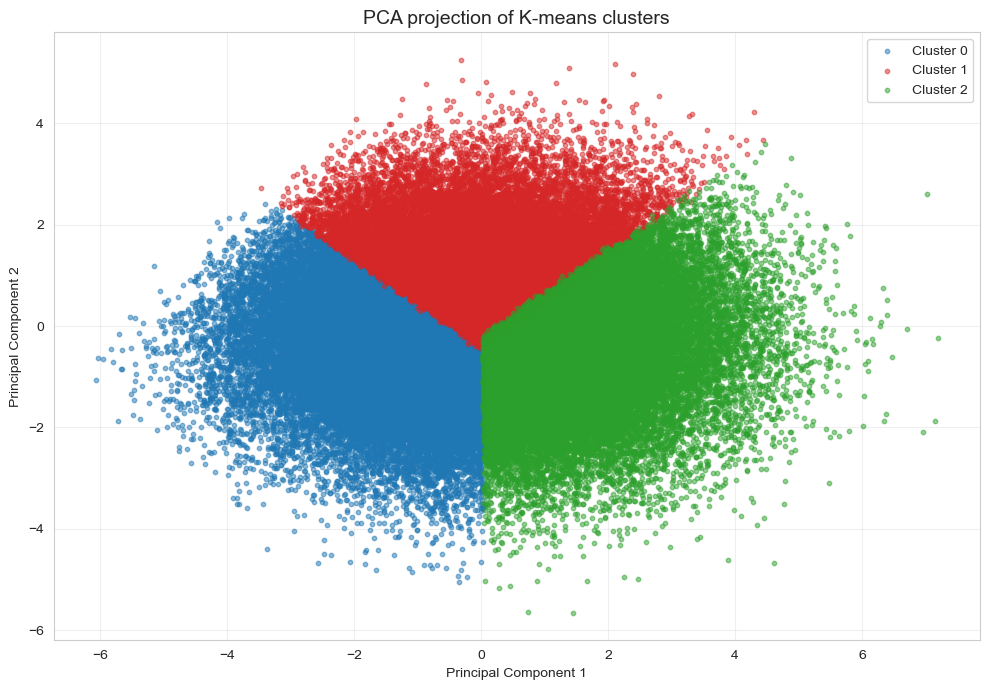

In [21]:
from sklearn.decomposition import PCA

# PCA to 2 components
pca = PCA(n_components=2, random_state=1)
X_pca = pca.fit_transform(X)

# Add PCA components to df for plotting
df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]

# Plot
plt.figure(figsize=(10, 7))

colors = {0: "#1f77b4", 1: "#d62728", 2: "#2ca02c"}
labels = {0: "Cluster 0", 1: "Cluster 1", 2: "Cluster 2"}

for c in [0, 1, 2]:
    subset = df[df["cluster_kmeans"] == c]
    plt.scatter(
        subset["PCA1"],
        subset["PCA2"],
        s=10,
        alpha=0.5,
        color=colors[c],
        label=labels[c]
    )

plt.title("PCA projection of K-means clusters", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 7) Hierarchical clustering (sample)

Hierarchical clustering is applied on a small random sample of the dataset because full dendrograms become unreadable and computationally expensive with large datasets (100,000 rows).

We use Ward linkage on scaled numerical features to visualise rough cluster structure and check whether it agrees with the K-means segmentation.

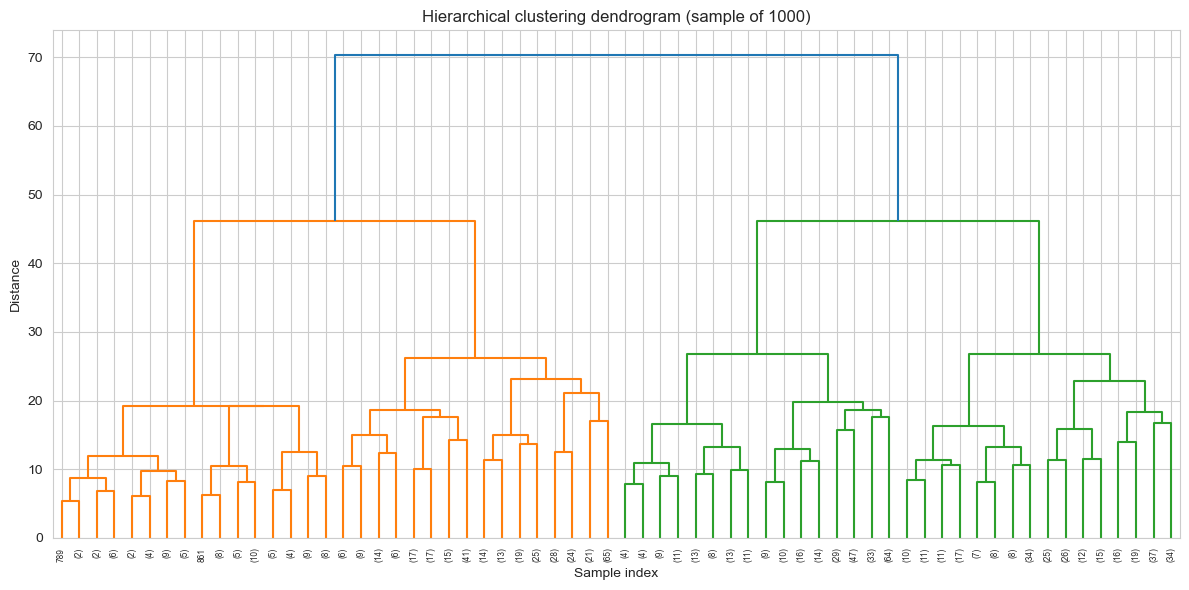

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage

sample_size = 1000
df_sample = df.sample(sample_size, random_state=42)
num_cols = df_sample.select_dtypes(include="number").columns.tolist()

# Scale numeric features
scaler = StandardScaler()
X_sample = scaler.fit_transform(df_sample[num_cols])

# Compute linkage matrix 
Z = linkage(X_sample, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=5)  # truncate to avoid overplotting
plt.title("Hierarchical clustering dendrogram (sample of 1000)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

#### Result
The hierarchical clustering dendrogram shows two major branches that only merge at a very high distance (around 70), indicating a strong separation between the main groups; each branch then splits into smaller subclusters at lower distances, so a natural cut around distance 40–50 would produce roughly three interpretable clusters, which aligns well with the previous k=3 K-means solution and confirms that the data contain a meaningful structure with about two to three larger clusters.